# 6.6 Preprocess 37-00027 (Austin, TX)

In [52]:
import geopandas
import matplotlib.pyplot as plt
import numpy
import pandas
import shapely

from cpe_help import Department, util

In [23]:
dept = Department('37-00027')
path = dept.tabular_input_dir / '37-00027_UOF-P_2014-2016_prepped.csv'
df = pandas.read_csv(path, low_memory=False, skiprows=[1])
df = df.rename(columns={
    'Y_COORDINATE': 'X_COORDINATE',
    'Y_COORDINATE.1': 'Y_COORDINATE',
})

def to_int(x):
    return numpy.nan if x in (numpy.nan, '-') else int(x)
df['X_COORDINATE'] = df['X_COORDINATE'].apply(to_int)
df['Y_COORDINATE'] = df['Y_COORDINATE'].apply(to_int)

df.head().T

,0,1,2,3,4
RIN,156701,161046,161381,142588,162084
PRIMARY_KEY,2015541517,20151510003,20151510003,2014111929,20151720001
INCIDENT_DATE,2/24/2015,5/31/2015,5/31/2015,1/11/2014,6/21/2015
LOCATION_DISTRICT,FR,GE,GE,HE,GE
INCIDENT_REASON,VIEWED OFFENSE,VIEWED OFFENSE,VIEWED OFFENSE,TRAFFIC STOP,DISPATCHED CALL
REASON_FOR_FORCE,NECESSARY TO EFFECT ARREST / DETENTION,NECESSARY TO EFFECT ARREST / DETENTION,"IN CUSTODY, MAINTAINING CONTROL",NECESSARY TO DEFEND REPORTING OFFICER,TO RESTRAIN FOR SUBJECTS SAFETY
SUBJECT_ID,167510327: 2015541517,459191174: 20151510003,459191174: 20151510003,198377769: 2014111929,459030448: 20151720001
SUBJECT_GENDER,M,M,M,M,M
SUBJECT_RACE,Hispanic,Hispanic,Hispanic,Black,Black
SUBJECT_ROLE,NaN,NaN,NaN,SUSPECT,NaN


# Date

We have a simple date.

In [6]:
date = df['INCIDENT_DATE']
datef = pandas.to_datetime(date, format='%m/%d/%Y')

In [7]:
datef.describe()

count                    9482
unique                   1077
top       2016-01-01 00:00:00
freq                       36
first     2014-01-01 00:00:00
last      2016-12-31 00:00:00
Name: INCIDENT_DATE, dtype: object

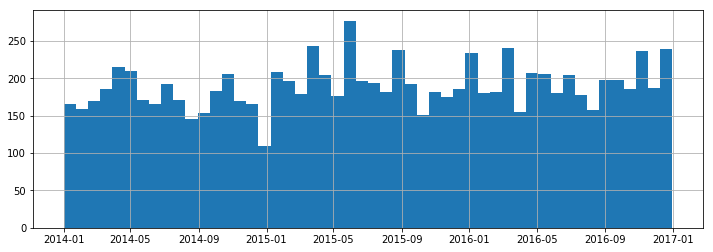

In [13]:
datef.hist(bins=50, figsize=(12, 4))

# Location

## X/Y Coordinates

I believe these coordinates are related to the CRS of the place.

Let's plot them first.

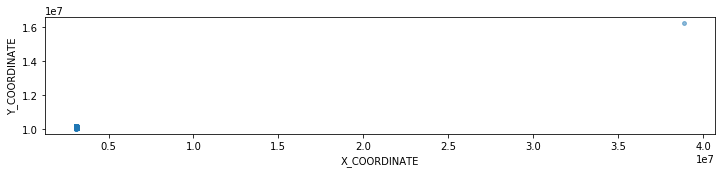

In [31]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_aspect('equal')

df.plot('X_COORDINATE', 'Y_COORDINATE', kind='scatter', s=15, alpha=0.5, ax=ax)

One outlier?

In [33]:
df['X_COORDINATE'].sort_values(ascending=False).head()

2093    38895239.0
8034     3156922.0
139      3156637.0
9348     3156637.0
2151     3156499.0
Name: X_COORDINATE, dtype: float64

In [34]:
df['Y_COORDINATE'].sort_values(ascending=False).head()

2093    16251772.0
4341    10155217.0
4342    10155217.0
1942    10153406.0
1941    10153406.0
Name: Y_COORDINATE, dtype: float64

In [35]:
df.loc[2093]

RIN                                                                                        175223
PRIMARY_KEY                                                                           20162321337
INCIDENT_DATE                                                                           8/19/2016
LOCATION_DISTRICT                                                                               -
INCIDENT_REASON                                                                   WARRANT SERVICE
REASON_FOR_FORCE                                           NECESSARY TO EFFECT ARREST / DETENTION
SUBJECT_ID                                                                 305924123: 20162321337
SUBJECT_GENDER                                                                                  M
SUBJECT_RACE                                                                                White
SUBJECT_ROLE                                                                                  NaN
SUBJECT_DESCRIPTION 

Not sure why, but there it is.

Let's plot the data without it.

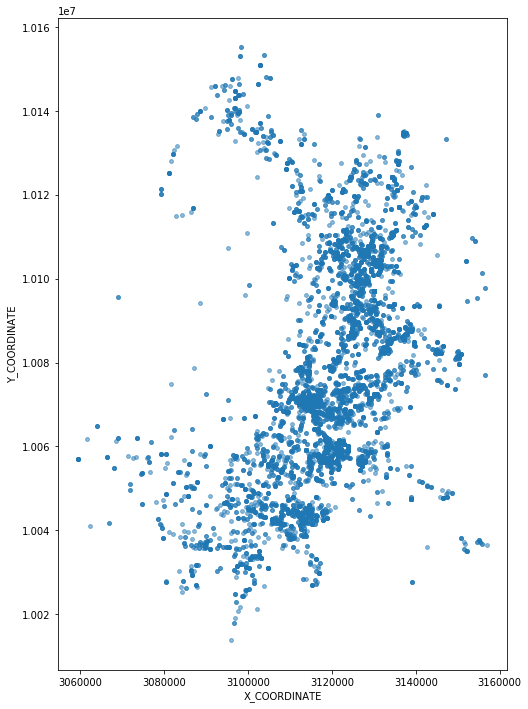

In [37]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_aspect('equal')

df.drop(2093).plot('X_COORDINATE', 'Y_COORDINATE', kind='scatter', s=15, alpha=0.5, ax=ax)

Feels like we are on track!

In [39]:
df['X_COORDINATE'].isnull().mean()

0.006116852984602405

In [65]:
df['Y_COORDINATE'].isnull().mean()

0.006116852984602405

In [41]:
(df['X_COORDINATE'].isnull() == df['Y_COORDINATE'].isnull()).all()

True

In [47]:
geocoded = (df['X_COORDINATE'].notnull()) & (df['X_COORDINATE'] < 1.0e7)

In [51]:
Point = shapely.geometry.Point
xs = df['X_COORDINATE']
ys = df['Y_COORDINATE']
points = [Point(x, y) if coded else Point()
          for x, y, coded in zip(xs, ys, geocoded)]
points[:5]

In [36]:
crs = dept.load_external_shapefile().crs
crs

{'init': 'esri:102739', 'no_defs': True}

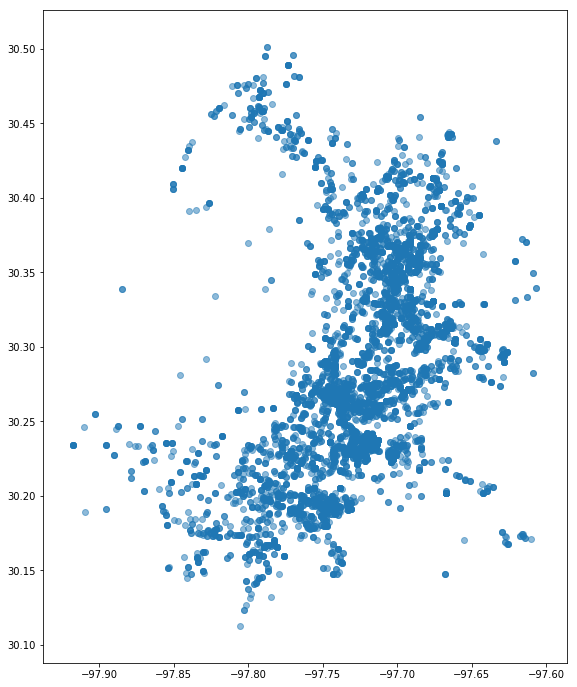

In [55]:
gdf = geopandas.GeoDataFrame(df, geometry=points, crs=crs)
gdf = gdf.to_crs(util.crs.epsg4326)
gdf.plot(alpha=0.5, figsize=(12, 12))

## Latitude/Longitude

In [56]:
lat = df['LOCATION_LATITUDE']
lon = df['LOCATION_LONGITUDE']

In [57]:
lat.isnull().mean()

0.772199957814807

In [58]:
lon.isnull().mean()

0.772199957814807

In [59]:
(lat.isnull() == lon.isnull()).all()

True

Check if plots are the same.

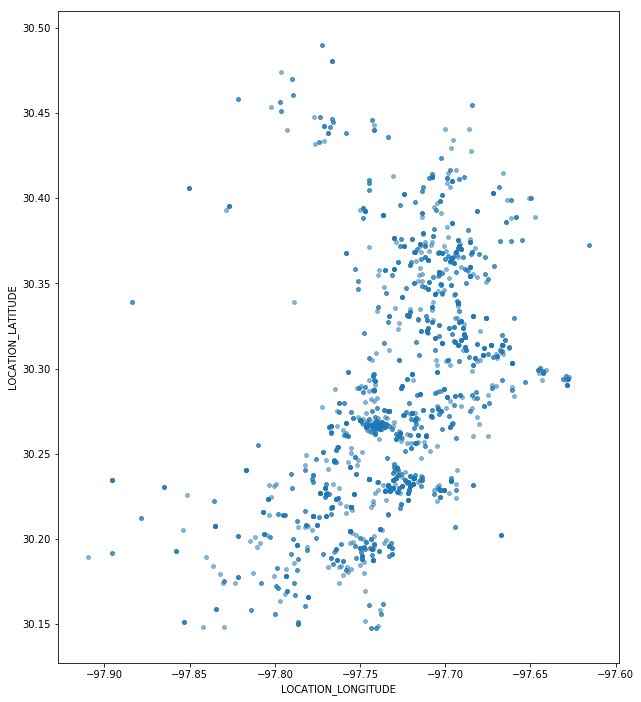

In [61]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_aspect('equal')

df.plot('LOCATION_LONGITUDE', 'LOCATION_LATITUDE', kind='scatter', alpha=0.5, s=15, ax=ax)

Maps seem to match!

## Combine

In [63]:
(lat.notnull() & ~geocoded).sum()

0

The latitude/longitude information cannot possibly help further than the X/Y coordinates!

## Conclusion

Despite the bad format, if we use X/Y coordinates, we can get the location of about 99.4% of the entries.

The Latitude/Longitude values have 77% nulls and don't add no new information.